In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [4]:
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE


In [5]:
# Plot တွေ Notebook ထဲမှာ တန်းမြင်ရဖို့# Plot တွေ Notebook ထဲမှာ တန်းမြင်ရဖို့
%matplotlib inline

Cell 2: Dataset ဖန်တီးခြင်း (Data Loading)

In [6]:
def generate_mock_data(n_samples=2000):
    np.random.seed(42)
    time = np.random.randint(0, 172792, n_samples)
    amount = np.random.uniform(0, 3000, n_samples)
    V_features = np.random.normal(0, 1, (n_samples, 28))
    #Create 28 features v1 to v28 with values from a normal distribution (mean=0,std=1)
    #Shape of this array is (2000, 28) --> 2000 rows and 28 columns

    columns = ['Time'] + [f'V{i}' for i in range (1,29)] + ['Amount']
    df = pd.DataFrame(np.column_stack([time, V_features, amount]), columns=columns)

    # Class 0 = ပုံမှန်၊ Class 1 = လိမ်လည်မှု (၅ ရာခိုင်နှုန်းပဲ ထည့်ထားပါတယ်)
    df['Class'] = np.random.choice([0,1], size=n_samples, p=[0.95,0.05])
    return df

In [7]:
df = generate_mock_data()

In [8]:
print("✅ Dataset Ready!")
df.head()

✅ Dataset Ready!


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,121958.0,1.192497,-0.120114,-0.182421,-0.484629,0.343067,0.308450,-0.666284,-0.177694,-0.659602,...,1.369255,-1.138567,-0.379404,0.332065,0.881183,-0.380242,-1.918100,-0.150104,1600.807640,0
1,146867.0,1.352028,0.282187,0.236418,-1.063018,-1.165672,0.018042,-1.426379,0.781362,-0.846646,...,1.223853,0.136822,-1.184360,-0.499384,1.702696,-0.074744,-3.324756,-1.468923,1823.715278,0
2,131932.0,-0.424449,1.035825,-0.273122,1.054432,-0.526162,-1.964293,-0.491561,0.344945,0.261950,...,-0.908650,-0.715048,0.441986,-0.430385,0.380381,-0.190841,0.067494,0.445086,2294.649785,0
3,103694.0,-0.350018,-0.996050,-0.532312,1.195139,0.116173,-0.844898,0.401561,0.468316,0.519999,...,-0.714547,-0.261705,0.829130,-0.027332,-0.656196,-0.732893,-0.069578,0.889988,2438.957216,0
4,119879.0,1.591019,-0.205769,-0.044743,-1.213942,1.939193,-1.401003,1.171662,-0.365336,-0.599366,...,-1.553132,-0.301497,0.249179,-0.893493,-0.814595,-0.546259,1.221236,-0.487158,2154.369229,0


## Cell 3: Data ကို လေ့လာခြင်း (Exploratory Data Analysis)

Dataset Shape: (2000, 31)

Class Counts:
Class
0    1905
1      95
Name: count, dtype: int64


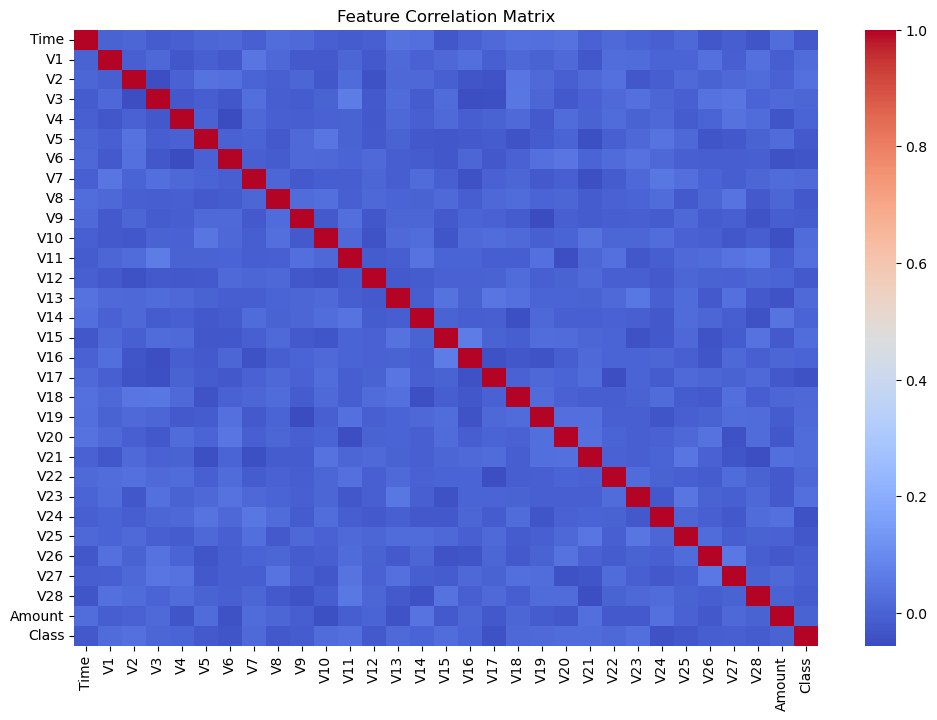

In [15]:
# Data ထဲမှာ feature တစ်ခုနဲ့တစ်ခု ဘယ်လိုဆက်စပ်နေလဲဆိုတာ Heatmap နဲ့ ကြည့်ပါမယ်။
print(f"Dataset Shape: {df.shape}")
print(f"\nClass Counts:\n{df['Class'].value_counts()}")

plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Matrix')
plt.show() #sns.heatmap(...)Correlation matrix ကို အရောင်နဲ့ပြတဲ့ ဇယား အဖြစ်ဖော်ပြတယ်
#cmap='coolwarm'
#အနီရောင် → Positive correlation
#အပြာရောင် → Negative correlation

#annot=False
#နံပါတ်တွေ မရေးပြဘဲ အရောင်နဲ့ပဲ ပြမယ်

## Cell 4: Train-Test Split & SMOTE (Balancing)

In [16]:
X = df.drop('Class', axis=1)
y = df['Class']

#80% train, 20% test ခွဲပါမယ်
X_train, X_test, y_train,y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Original Fraud cases in training: {sum(y_train==1)}")

Original Fraud cases in training: 76


In [18]:
# SMOTE သုံးပြီး balance လုပ်ခြင်း
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train,y_train)

print(f"After SMOTE, Fraud cases: {sum(y_train_resampled ==1)}")

C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

After SMOTE, Fraud cases: 1524


# Cell 5: Pipeline & Hyperparameter Tuning
StandardScaler နဲ့ Random Forest ကို Pipeline တစ်ခုတည်းအဖြစ် ပေါင်းပြီး GridSearchCV နဲ့ tuning လုပ်ပါမယ်။

In [19]:
# Pipeline တည်ဆောက်ခြင်း
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier',RandomForestClassifier(random_state=42))
])

# စမ်းသပ်မယ့် parameter များ
param_grid = {
    'classifier__n_estimators': [50,100],
    'classifier__max_depth': [None, 10],
    'classifier__min_samples_split': [2,5]
}

#Node တစ်ခုကို ခွဲဖို့ လိုအပ်တဲ့ minimum sample အရေအတွက်
#2 → sample 2 ခုရှိရင် ခွဲနိုင်
#5 → sample 5 ခုရှိမှ ခွဲနိုင်
#👉 နည်းလေ → Model က အသေးစိတ်လေ့လာ (overfit)
#👉 များလေ → Model က simple ဖြစ် (underfit ဖြစ်နိုင်)

In [22]:
# Grid Search စတင်ခြင်း
grid_model = GridSearchCV(pipeline, param_grid,cv=3,scoring='recall', n_jobs=-1)

#n_jobs=-1
#CPU core အားလုံးကို အသုံးပြုမယ်
#Recall = TP / (TP + FN)

grid_model.fit(X_train_resampled, y_train_resampled)
print(f"Best Parameters: {grid_model.best_params_}")

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


## Cell 6: Evaluation (Model ကို စစ်ဆေးခြင်း)
Model က ဘယ်လောက်အစွမ်းထက်လဲဆိုတာ ROC Curve နဲ့ Confusion Matrix နဲ့ ကြည့်ပါမယ်။

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       381
           1       0.03      0.05      0.04        19

    accuracy                           0.86       400
   macro avg       0.49      0.48      0.48       400
weighted avg       0.91      0.86      0.89       400



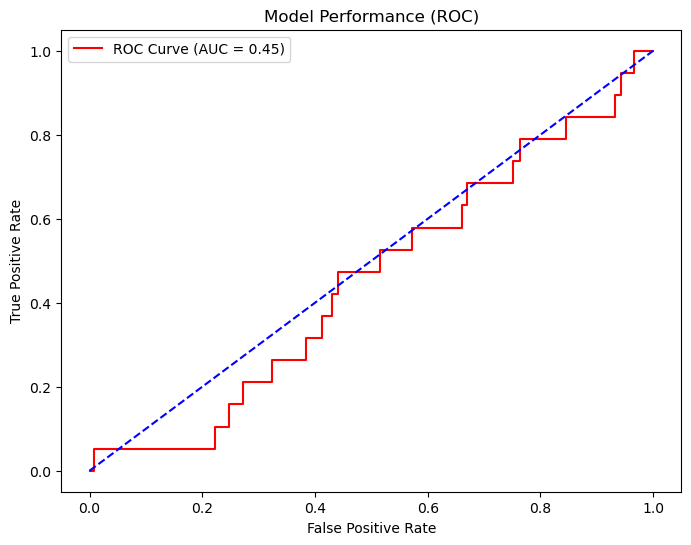

In [25]:
y_pred = grid_model.predict(X_test)
y_prob = grid_model.predict_proba(X_test)[:, 1]

print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# ROC Curve ဆွဲခြင်း
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model Performance (ROC)')
plt.legend()
plt.show()

In [26]:
joblib.dump(grid_model.best_estimator_, 'fraud_detection_model.pkl')
print("✅ Model saved as 'fraud_detection_model.pkl'")

✅ Model saved as 'fraud_detection_model.pkl'
